# Application of Deep Learning to Predict Persistence, Bioaccumulation and Toxicity of Pharmaceuticals

This notebook illustates the section Interpretability Analysis Application to Pharmaceuticals in the paper "Application of Deep Learning to Predict Persistence, Bioaccumulation and Toxicity of Pharmaceuticals". It describes the extraction of PBT-relevan substructures through chemprop built-in interpret function.
## Environment Setup

To execute this notebook, use the main conda environment (created using environment_main.yaml). If running in terminal activate using:

```bash
conda activate main_DE
```

In [1]:
import pandas as pd
import rdkit
import rdkit, rdkit.Chem, rdkit.Chem.Draw
from rdkit import Chem
from rdkit.Chem import Descriptors
from rdkit.Chem import Fragments, rdMolDescriptors, rdchem, PandasTools, EState
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from rdkit.Chem import AllChem
from rdkit.Chem import Draw, BondType, AllChem as Chem, rdFingerprintGenerator
from rdkit.Chem import rdmolops
from collections import defaultdict

## Interpretability Analysis

In the following section, we will identify **specific chemical substructures** that are linked to PBT (Persistence, Bioaccumulation, and Toxicity) classification using the built-in `interpret` function in Chemprop. We will start with the dataset of cluster centroids from our compiled dataset to interpret our proposed model. By identifying key molecular substructures, we aim to pinpoint which parts of each molecule are primarily responsible for Chemprop’s predictions.

In [2]:
Centres_trainmol = pd.read_csv('Splitting_strategy_datasets/new_Cluster_centroids_training_PBT.csv')
Centres_trainmol

,standardized_smiles,PBT_label
0,Clc1ccc2c(Cl)ccnc2c1,0
1,NC(=Nc1ccccc1)Nc1ccccc1,0
2,O=C1OC(c2cc(Br)c(O)c(Br)c2)(c2cc(Br)c(O)c(Br)c...,1
3,COC(=O)C(F)(F)F,0
4,O=C1c2ccccc2C(=O)c2ccccc21,0
...,...,...
579,CC(C)C(NC(N)=O)NC(N)=O,0
580,C[Si](NC1CCCCC1)(NC1CCCCC1)NC1CCCCC1,0
581,O=C1CCCCCN1C(=O)Nc1ccc(Cc2ccc(NC(=O)N3CCCCCC3=...,0
582,CC1(C)CC(N(C=O)CCCCCCN(C=O)C2CC(C)(C)NC(C)(C)C...,0


To execute the interpretation run using `chemprop` in a Bash environment:

Open a new bash shell and execute the following commands:

1. **Activate the Conda Environment**  
   First, make sure to activate the `chemprop_DE` Conda environment to access the required dependencies:
   
   ```bash
   conda activate chemprop_DE
   ```

2. Run **Chemprop Interpret** Command


```bash
chemprop_interpret \
    --data_path /path/to/your/new_Cluster_centroids_training_PBT.csv \
    --features_generator rdkit_2d_normalized \
    --no_features_scaling \
    --min_atoms 4 \
    --checkpoint_dir CC_results_nok/fold_0/ \
    --property_id 1 \
    >> /path/to/your/Oct_interpret_CS_PBT2.log &
```

In [3]:
## !chemprop_interpret --data_path Splitting_strategy_datasets/new_Cluster_centroids_training_PBT.csv --features_generator rdkit_2d_normalized --no_features_scaling --min_atoms 4 --checkpoint_dir CC_results_nok/fold_0/ --property_id 1 >> Oct_interpret_CS_PBT2.log &

In [4]:
## Elapsed time = 4:49:09

3. after completing the **Interpret command** in bash returns to this notebook

### **Substructure Interpretation Analysis**

In the following section, we use the output ftom the '**interpret**' run (***Oct_interpret_CS_PBT2.log***) to extract substructures responsible for **PBT** (Persistent, Bioaccumulative, and Toxic) behaviour, . 

**Key findings**:
- **198** substructures were identified as responsible for PBT behavior in at least one compound
- Among these, **18** substructures appeared multiple times
- After applying RDKit's **FindMCS()** function:
  - The 18 recurring substructures were consolidated into **13** PBT-related substructures
  - **3** PBT-associated Maximum Common Substructures (MCSs) were identified

**Analysis of Substructure Distribution**:
- Counted matched molecules containing these substructures for:
  - PBT and non-PBT molecules in the experimental dataset
  - PBT and non-PBT molecules in the prediction dataset
- Calculated **Enrichment Factor (EF)** for both:
  - Experimental dataset
  - Prediction dataset

In [6]:
interpret_cc = pd.read_csv('outputs_pred_interpr/Oct_interpret_CS_PBT2.log')
# Remove square brackets from SMILES strings
interpret_cc['smiles'] = interpret_cc['smiles'].str.strip("['']")
interpret_cc

,smiles,PBT_label,rationale,rationale_score
0,Clc1ccc2c(Cl)ccnc2c1,0.223,NaN,NaN
1,NC(=Nc1ccccc1)Nc1ccccc1,0.002,NaN,NaN
2,O=C1OC(c2cc(Br)c(O)c(Br)c2)(c2cc(Br)c(O)c(Br)c...,0.993,Brc1c[cH:1]cc(Br)[cH:1]1,0.504
3,COC(=O)C(F)(F)F,0.006,NaN,NaN
4,O=C1c2ccccc2C(=O)c2ccccc21,0.023,NaN,NaN
...,...,...,...,...
579,CC(C)C(NC(N)=O)NC(N)=O,0.000,NaN,NaN
580,C[Si](NC1CCCCC1)(NC1CCCCC1)NC1CCCCC1,0.079,NaN,NaN
581,O=C1CCCCCN1C(=O)Nc1ccc(Cc2ccc(NC(=O)N3CCCCCC3=...,0.674,NaN,NaN
582,CC1(C)CC(N(C=O)CCCCCCN(C=O)C2CC(C)(C)NC(C)(C)C...,0.576,NaN,NaN


In [7]:
# Drop nan values
filtered_df = interpret_cc.dropna(subset=['rationale', 'rationale_score'])
# Replace ':1' with '' in the 'substructure' column
filtered_df['Substructure'] = filtered_df['rationale'].str.replace(':1', '', regex=False)
filtered_df

/common/users/devan/anaconda3/envs/main_DE/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,smiles,PBT_label,rationale,rationale_score,Substructure
2,O=C1OC(c2cc(Br)c(O)c(Br)c2)(c2cc(Br)c(O)c(Br)c...,0.993,Brc1c[cH:1]cc(Br)[cH:1]1,0.504,Brc1c[cH]cc(Br)[cH]1
10,COc1c(Cl)c(Cl)c(Cl)c(Cl)c1Cl,0.993,Clc1c(Cl)[cH:1][cH:1][cH:1]c1Cl,0.831,Clc1c(Cl)[cH][cH][cH]c1Cl
11,FC(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F...,1.000,FC(F)([CH3:1])[CH:1](F)F,0.659,FC(F)([CH3])[CH](F)F
13,CC1CCC2(OC1)OC1CC3C4CC=C5CC(O)CCC5(C)C4CCC3(C)...,0.973,CC12CC[CH2:1]CC1=CCC1C2CC[CH:1]2C1C[CH2:1][CH2...,0.750,CC12CC[CH2]CC1=CCC1C2CC[CH]2C1C[CH2][CH2]2
14,COc1ccc(C(c2ccc(OC)cc2)C(Cl)(Cl)Cl)cc1,0.743,ClC(Cl)(Cl)C(c1cc[cH:1]cc1)c1cc[cH:1]cc1,0.566,ClC(Cl)(Cl)C(c1cc[cH]cc1)c1cc[cH]cc1
...,...,...,...,...,...
328,O=C(O)C=C(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F...,1.000,FC(F)(F)[CH:1](F)F,0.795,FC(F)(F)[CH](F)F
361,CCCCC(CC)COP1Oc2c(cc(C(C)(C)C)cc2C(C)(C)C)Cc2c...,0.997,c1c2c(c([CH3:1])c[cH:1]1)O[PH:1]Oc1c(c[cH:1]cc...,0.567,c1c2c(c([CH3])c[cH]1)O[PH]Oc1c(c[cH]cc1[CH3])C2
373,C=CC(=O)Oc1c(C(C)c2cc(C(C)(C)CC)cc(C(C)(C)CC)c...,0.983,c1c([CH3:1])cc([CH2:1]c2cc([CH3:1])cc([CH3:1])...,0.606,c1c([CH3])cc([CH2]c2cc([CH3])cc([CH3])[cH]2)[c...
408,CC(=O)Oc1c(C)c(C)c2c(c1C)CCC(C)(CCCC(C)CCCC(C)...,0.949,Cc1c2c([cH:1][cH:1]c1C)CCC(C)([CH3:1])O2,0.569,Cc1c2c([cH][cH]c1C)CCC(C)([CH3])O2


In [8]:
### canonicalize smiles strings
filtered_df['mol'] = filtered_df.apply(lambda x: Chem.MolFromSmiles(x['Substructure']), axis=1)
filtered_df['canonical_smi'] = filtered_df.apply(lambda x: Chem.MolToSmiles(x['mol']), axis=1)
filtered_df

/common/users/devan/anaconda3/envs/main_DE/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/common/users/devan/anaconda3/envs/main_DE/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,smiles,PBT_label,rationale,rationale_score,Substructure,mol,canonical_smi
2,O=C1OC(c2cc(Br)c(O)c(Br)c2)(c2cc(Br)c(O)c(Br)c...,0.993,Brc1c[cH:1]cc(Br)[cH:1]1,0.504,Brc1c[cH]cc(Br)[cH]1,<rdkit.Chem.rdchem.Mol object at 0x7fdc626ed630>,Brc1cccc(Br)c1
10,COc1c(Cl)c(Cl)c(Cl)c(Cl)c1Cl,0.993,Clc1c(Cl)[cH:1][cH:1][cH:1]c1Cl,0.831,Clc1c(Cl)[cH][cH][cH]c1Cl,<rdkit.Chem.rdchem.Mol object at 0x7fdc626ed570>,Clc1cccc(Cl)c1Cl
11,FC(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F...,1.000,FC(F)([CH3:1])[CH:1](F)F,0.659,FC(F)([CH3])[CH](F)F,<rdkit.Chem.rdchem.Mol object at 0x7fdc626edc90>,CC(F)(F)C(F)F
13,CC1CCC2(OC1)OC1CC3C4CC=C5CC(O)CCC5(C)C4CCC3(C)...,0.973,CC12CC[CH2:1]CC1=CCC1C2CC[CH:1]2C1C[CH2:1][CH2...,0.750,CC12CC[CH2]CC1=CCC1C2CC[CH]2C1C[CH2][CH2]2,<rdkit.Chem.rdchem.Mol object at 0x7fdc626edcf0>,CC12CCCCC1=CCC1C3CCCC3CCC12
14,COc1ccc(C(c2ccc(OC)cc2)C(Cl)(Cl)Cl)cc1,0.743,ClC(Cl)(Cl)C(c1cc[cH:1]cc1)c1cc[cH:1]cc1,0.566,ClC(Cl)(Cl)C(c1cc[cH]cc1)c1cc[cH]cc1,<rdkit.Chem.rdchem.Mol object at 0x7fdc626ed870>,ClC(Cl)(Cl)C(c1ccccc1)c1ccccc1
...,...,...,...,...,...,...,...
328,O=C(O)C=C(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F...,1.000,FC(F)(F)[CH:1](F)F,0.795,FC(F)(F)[CH](F)F,<rdkit.Chem.rdchem.Mol object at 0x7fdc619eb4b0>,FC(F)C(F)(F)F
361,CCCCC(CC)COP1Oc2c(cc(C(C)(C)C)cc2C(C)(C)C)Cc2c...,0.997,c1c2c(c([CH3:1])c[cH:1]1)O[PH:1]Oc1c(c[cH:1]cc...,0.567,c1c2c(c([CH3])c[cH]1)O[PH]Oc1c(c[cH]cc1[CH3])C2,<rdkit.Chem.rdchem.Mol object at 0x7fdc619eb510>,Cc1cccc2c1OPOc1c(C)cccc1C2
373,C=CC(=O)Oc1c(C(C)c2cc(C(C)(C)CC)cc(C(C)(C)CC)c...,0.983,c1c([CH3:1])cc([CH2:1]c2cc([CH3:1])cc([CH3:1])...,0.606,c1c([CH3])cc([CH2]c2cc([CH3])cc([CH3])[cH]2)[c...,<rdkit.Chem.rdchem.Mol object at 0x7fdc619eb570>,Cc1cc(C)cc(Cc2cc(C)cc(C)c2)c1
408,CC(=O)Oc1c(C)c(C)c2c(c1C)CCC(C)(CCCC(C)CCCC(C)...,0.949,Cc1c2c([cH:1][cH:1]c1C)CCC(C)([CH3:1])O2,0.569,Cc1c2c([cH][cH]c1C)CCC(C)([CH3])O2,<rdkit.Chem.rdchem.Mol object at 0x7fdc619eb5d0>,Cc1ccc2c(c1C)OC(C)(C)CC2


In [9]:
PBT_substructures = filtered_df[['canonical_smi', 'PBT_label', 'rationale_score']]
PBT_substructures

,canonical_smi,PBT_label,rationale_score
2,Brc1cccc(Br)c1,0.993,0.504
10,Clc1cccc(Cl)c1Cl,0.993,0.831
11,CC(F)(F)C(F)F,1.000,0.659
13,CC12CCCCC1=CCC1C3CCCC3CCC12,0.973,0.750
14,ClC(Cl)(Cl)C(c1ccccc1)c1ccccc1,0.743,0.566
...,...,...,...
328,FC(F)C(F)(F)F,1.000,0.795
361,Cc1cccc2c1OPOc1c(C)cccc1C2,0.997,0.567
373,Cc1cc(C)cc(Cc2cc(C)cc(C)c2)c1,0.983,0.606
408,Cc1ccc2c(c1C)OC(C)(C)CC2,0.949,0.569


In [10]:
## collect substructures recurring more than once
counts = dict(PBT_substructures['canonical_smi'].value_counts())
vals = {k:v for k,v in counts.items() if v>=2}
vals

{'Brc1cccc(Br)c1': 10,
 'CC(F)(F)C(F)F': 10,
 'Clc1cccc(Cl)c1Cl': 9,
 'FC(F)C(F)(F)F': 8,
 'Brc1ccccc1Br': 6,
 'CC12CCCC1C1CCCCC1CC2': 4,
 'CC12CCCCC1=CCC1C3CCCC3CCC12': 3,
 'CSc1nc(C)nc(C(Cl)(Cl)Cl)n1': 3,
 'Clc1ccc(Cl)c(Cl)c1': 3,
 'c1cc2ccc3cccc4ccc(c1)c2c34': 2,
 'c1ccc2cc3c(ccc4ccccc43)cc2c1': 2,
 'c1ccc2c(c1)Cc1ccccc1S2': 2,
 'ClC(Cl)(Cl)c1ncnc(C(Cl)(Cl)Cl)n1': 2,
 'ClC(Cl)C(Cl)Cl': 2,
 'Clc1cc(Cl)cc(Cl)c1': 2,
 'Clc1ccc(Cl)c(Br)c1': 2,
 'Cc1c(Cl)cccc1Cl': 2,
 'Ic1cccc(I)c1I': 2}

In [11]:
len(vals)

18

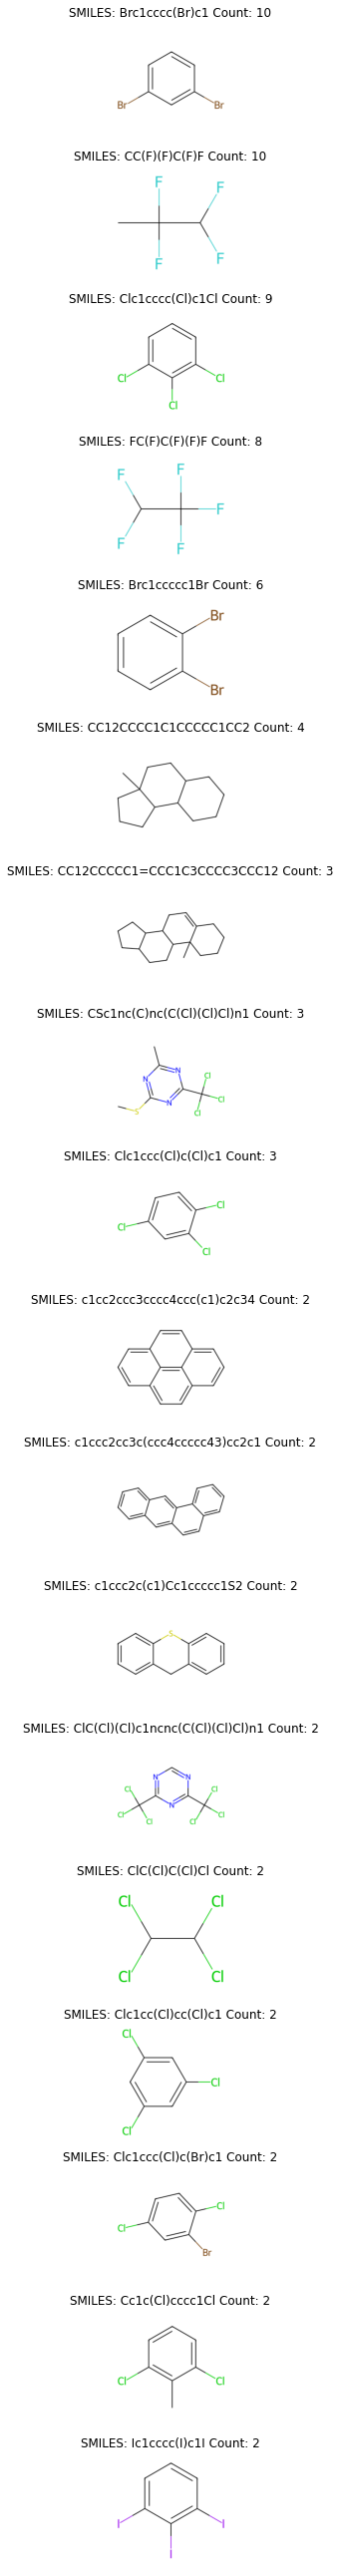

In [12]:
# Create a list of molecule objects from SMILES strings
mols = [Chem.MolFromSmiles(smiles) for smiles in vals.keys()]

# Setting up the plot
fig, axes = plt.subplots(nrows=len(mols), figsize=(10, len(mols) * 2))

# If there is only one molecule, we need to ensure axes is iterable
if len(mols) == 1:
    axes = [axes]

# Draw each molecule with its SMILE and count
for ax, mol, (smiles, count) in zip(axes, mols, vals.items()):
    img = Draw.MolToImage(mol, size=(300, 300))
    ax.imshow(img)
    ax.axis('off')
    ax.set_title(f'SMILES: {smiles} Count: {count}')

plt.tight_layout()
plt.show()

In [13]:
# Create lists for DataFrame Substructures construction
smiles_list = list(vals.keys())
mol_objects = [Chem.MolFromSmiles(sm) for sm in smiles_list]
counts_list = list(vals.values())

# Create the DataFrame
sub = pd.DataFrame({
    'smiles_substructures': smiles_list,
    'mol': mol_objects,
    'Count': counts_list
})

sub

,smiles_substructures,mol,Count
0,Brc1cccc(Br)c1,<rdkit.Chem.rdchem.Mol object at 0x7fdc5edcd330>,10
1,CC(F)(F)C(F)F,<rdkit.Chem.rdchem.Mol object at 0x7fdc5edc9f90>,10
2,Clc1cccc(Cl)c1Cl,<rdkit.Chem.rdchem.Mol object at 0x7fdc5edc9390>,9
3,FC(F)C(F)(F)F,<rdkit.Chem.rdchem.Mol object at 0x7fdc5edc9a50>,8
4,Brc1ccccc1Br,<rdkit.Chem.rdchem.Mol object at 0x7fdc5edc99f0>,6
5,CC12CCCC1C1CCCCC1CC2,<rdkit.Chem.rdchem.Mol object at 0x7fdc5edc9810>,4
6,CC12CCCCC1=CCC1C3CCCC3CCC12,<rdkit.Chem.rdchem.Mol object at 0x7fdc5edc9330>,3
7,CSc1nc(C)nc(C(Cl)(Cl)Cl)n1,<rdkit.Chem.rdchem.Mol object at 0x7fdc5edc9bd0>,3
8,Clc1ccc(Cl)c(Cl)c1,<rdkit.Chem.rdchem.Mol object at 0x7fdc5edc9450>,3
9,c1cc2ccc3cccc4ccc(c1)c2c34,<rdkit.Chem.rdchem.Mol object at 0x7fdc5edc9b10>,2


#### **Find Maximum Common Substructures for some of them**

In [54]:
### Mols containing an aromatic ring and chlorine atoms
from rdkit import Chem
Clmols = [sub['mol'][2],
          sub['mol'][8], 
          sub['mol'][14], 
          sub['mol'][16]]
from rdkit.Chem import MCS
MCS.FindMCS(Clmols)

/common/users/devan/anaconda3/envs/main_DE/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: The rdkit.Chem.MCS module is deprecated; please use rdkit.Chem.rdFMCS instead.
  


MCSResult(numAtoms=8, numBonds=8, smarts='[Cl]-[#6]:1:[#6]:[#6]:[#6]:[#6](:[#6]:1)-[Cl]', completed=1)

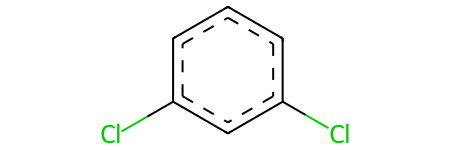

In [55]:
Clar1 = Chem.MolFromSmarts('[Cl]-[#6]:1:[#6]:[#6]:[#6]:[#6](:[#6]:1)-[Cl]')
Clar1

In [56]:
### Mols containing Fluorine atoms
Fmols = [sub['mol'][1], 
        sub['mol'][3]]
from rdkit.Chem import MCS
MCS.FindMCS(Fmols)

/common/users/devan/anaconda3/envs/main_DE/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: The rdkit.Chem.MCS module is deprecated; please use rdkit.Chem.rdFMCS instead.
  """


MCSResult(numAtoms=6, numBonds=5, smarts='[#6](-[#6](-[F])-[F])(-[F])-[F]', completed=1)

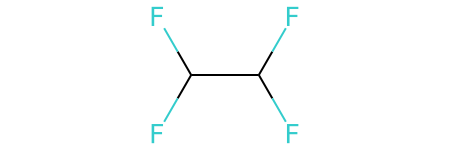

In [57]:
Fsub = Chem.MolFromSmarts('[#6](-[#6](-[F])-[F])(-[F])-[F]')
Fsub

In [58]:
### Mols containing Nitrogens and Chlorine atoms
Fmols = [sub['mol'][7], 
        sub['mol'][12]]
from rdkit.Chem import MCS
MCS.FindMCS(Fmols)

/common/users/devan/anaconda3/envs/main_DE/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: The rdkit.Chem.MCS module is deprecated; please use rdkit.Chem.rdFMCS instead.
  """


MCSResult(numAtoms=11, numBonds=11, smarts='[#6]:1:[#7]:[#6](:[#7]:[#6](:[#7]:1)-[#6](-[Cl])(-[Cl])-[Cl])-[#6]', completed=1)

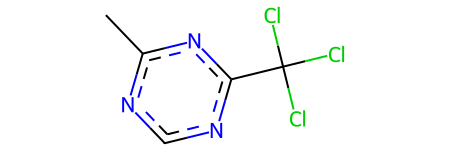

In [59]:
NClsub = Chem.MolFromSmarts('[#6]:1:[#7]:[#6](:[#7]:[#6](:[#7]:1)-[#6](-[Cl])(-[Cl])-[Cl])-[#6]')
NClsub

In [60]:
CSs = [sub['mol'][0], Fsub, Clar1, sub['mol'][4], sub['mol'][5], sub['mol'][6], sub['mol'][9], sub['mol'][10], sub['mol'][11], sub['mol'][13], sub['mol'][15], sub['mol'][17],  NClsub]
CSs

In [61]:
len(CSs)

13

In [62]:
smiles_list = [Chem.MolToSmiles(mol) for mol in CSs]

df13_sub = pd.DataFrame(smiles_list, columns=['SMILES'])
df13_sub

,SMILES
0,Brc1cccc(Br)c1
1,FC(F)C(F)F
2,ClC1:C:C:C:C(Cl):C:1
3,Brc1ccccc1Br
4,CC12CCCC1C1CCCCC1CC2
5,CC12CCCCC1=CCC1C3CCCC3CCC12
6,c1cc2ccc3cccc4ccc(c1)c2c34
7,c1ccc2cc3c(ccc4ccccc43)cc2c1
8,c1ccc2c(c1)Cc1ccccc1S2
9,ClC(Cl)C(Cl)Cl


In [63]:
#df13_sub.to_csv('outputs_pred_interpr/13substructures_smi.csv', index= False)

For each subsstructure identified we will count the matching molecules among PBT and non-PBT compounds together with an **enrichment factor (EF)**. EF values above 1 will indicate that the substructure is more often displayed by PBT compounds.

In [64]:
startPBT_correct = pd.read_csv('Datasets/5130compounds_PBT.csv')
startPBT_correct['mol'] = startPBT_correct.apply(lambda x: Chem.MolFromSmiles(x['standardized_smiles']), axis=1)
startPBT_correct

,standardized_smiles,PBT_label,mol
0,CCCC[Sn](CCCC)(CCCC)O[Sn](CCCC)(CCCC)CCCC,1,<rdkit.Chem.rdchem.Mol object at 0x7fdc5f53be10>
1,C=C(F)C(=O)OC,0,<rdkit.Chem.rdchem.Mol object at 0x7fdc5f53bf30>
2,Cc1c(Cl)c(Cl)c(Cl)c(Cl)c1Cl,1,<rdkit.Chem.rdchem.Mol object at 0x7fdc5f53bd50>
3,Clc1ccc2c(Cl)ccnc2c1,0,<rdkit.Chem.rdchem.Mol object at 0x7fdc5f52d210>
4,S=c1[nH]c2ccccc2s1,0,<rdkit.Chem.rdchem.Mol object at 0x7fdc5f52d390>
...,...,...,...
5125,CN(C)CCCN(C)C,0,<rdkit.Chem.rdchem.Mol object at 0x7fdc5d0070f0>
5126,C[N+](C)(C)C1CCCCC1,0,<rdkit.Chem.rdchem.Mol object at 0x7fdc5d007150>
5127,c1ccc(N(CC2CO2)CC2CO2)cc1,0,<rdkit.Chem.rdchem.Mol object at 0x7fdc5d0071b0>
5128,CCCCCCCCCCCC(=O)N(CCO)CCO,0,<rdkit.Chem.rdchem.Mol object at 0x7fdc5d007210>


### **Table 4**

### **PBT-relevant substructures from the dataset assembled for this study.**

The following code analyzes each substructure in `CSs` to identify matching molecules within the `startPBT_correct` dataset and calculates an enrichment factor. Here’s a breakdown of the process:

1. **Calculate Dataset Totals**: 
   - `total_hits_dataset`: Total count of molecules labeled `1` in `PBT_label`.
   - `total_molecules_dataset`: Total number of molecules in `startPBT_correct`.

2. **Find and Count Matches**: For each substructure:
   - Detects which molecules in `startPBT_correct` contain the substructure.
   - Filters matched molecules and counts `PBT_label` values of `1` (positive) and `0` (negative).

3. **Compute Enrichment Factor**:
   - Calculates the enrichment factor by comparing the proportion of positive matches for each substructure to the overall positive rate in the dataset. (If no matches are found, the factor is set to "undefined" to avoid division by zero.)

4. **Display Results**:
   - For each substructure (`CS {i}`), the code prints:
     - SMILES representation.
     - Total matches.
     - Counts of labels `1` and `0`.
     - Enrichment factor.

In [25]:
print("CSs in the experimental dataset")

# Calculate the total hits and total molecules in the entire dataset
total_hits_dataset = sum(startPBT_correct['PBT_label'])
total_molecules_dataset = len(startPBT_correct)

# Iterate through each substructure and perform the analysis
for i, substructure in enumerate(CSs):
    # Find matches for the current substructure in the dataset
    highlight_lists = [mol.GetSubstructMatch(substructure) for mol in startPBT_correct['mol']]
    
    # Filter matched molecules
    matched_indices = [i for i, match in enumerate(highlight_lists) if match]
    matched_molecules = startPBT_correct.iloc[matched_indices]
    
    # Extract PBT_labels for matched molecules
    matched_labels = matched_molecules['PBT_label']
    
    # Count occurrences of 1 and 0 in PBT_labels
    count_label_1 = sum(matched_labels)
    count_label_0 = len(matched_labels) - count_label_1
    
    # Count the total number of substructure matches (highlighted)
    total_matches = len(matched_indices)
    
    # Convert substructure Mol object to SMILES for display
    substructure_name = Chem.MolToSmiles(substructure)
    
    # Compute the enrichment factor
    if total_molecules_dataset > 0 and total_matches > 0:
        enrichment_factor = (count_label_1 / total_hits_dataset) / (total_matches/ total_molecules_dataset)
    else:
        enrichment_factor = 'undefined'  # Avoid division by zero
    
    # Print results
    print(f"CS {i}: {substructure_name}")
    print(f"Total matches: {total_matches}")
    print(f"Count of '1' in PBT_label: {count_label_1}")
    print(f"Count of '0' in PBT_label: {count_label_0}")
    print(f"Enrichment Factor: {enrichment_factor}")
    print("-" * 40)

CSs in the experimental dataset
CS 0: Brc1cccc(Br)c1
Total matches: 121
Count of '1' in PBT_label: 114
Count of '0' in PBT_label: 7
Enrichment Factor: 1.7834771736147113
----------------------------------------
CS 1: FC(F)C(F)F
Total matches: 304
Count of '1' in PBT_label: 292
Count of '0' in PBT_label: 12
Enrichment Factor: 1.8182656826568264
----------------------------------------
CS 2: ClC1:C:C:C:C(Cl):C:1
Total matches: 271
Count of '1' in PBT_label: 251
Count of '0' in PBT_label: 20
Enrichment Factor: 1.753284949823668
----------------------------------------
CS 3: Brc1ccccc1Br
Total matches: 70
Count of '1' in PBT_label: 68
Count of '0' in PBT_label: 2
Enrichment Factor: 1.8389035318924618
----------------------------------------
CS 4: CC12CCCC1C1CCCCC1CC2
Total matches: 79
Count of '1' in PBT_label: 73
Count of '0' in PBT_label: 6
Enrichment Factor: 1.749217618758466
----------------------------------------
CS 5: CC12CCCCC1=CCC1C3CCCC3CCC12
Total matches: 24
Count of '1' in PBT

We then count also the 13 substructures in the **prediction dataset** togethet with the **Enrichment Falctor**. To obtain the predictions by our proposed models on our entire compiled dataset, we will follow these steps:

In [26]:
startPBT_correct['standardized_smiles'].to_csv('Datasets/5130smiles_PBT-nonPBT.csv', index = False)

To run the model predicting using `chemprop` in a Bash environment:

Open a new bash shell and execute the following commands:

1. **Activate the Conda Environment**  
   First, make sure to activate the `chemprop_DE` Conda environment to access the required dependencies:
   
   ```bash
   conda activate chemprop_DE
   ```

2. Run the **Prediction Command**

chemprop_predict --test_path path/5130smiles_PBT-nonPBT.csv \
                 --features_generator rdkit_2d_normalized \
                 --no_features_scaling \
                 --checkpoint_dir CC_results_nok/fold_0/ \
                 --preds_path path/compiled_dataset_totalpred.csv

In [29]:
##!chemprop_predict --test_path Datasets/5130smiles_PBT-nonPBT.csv  --features_generator rdkit_2d_normalized --no_features_scaling --checkpoint_dir CC_results_nok/fold_0/ --preds_path outputs_pred_interpr/compiled_dataset_totalpred.csv

3. after completing the **Prediction command** in bash returns to this notebook

In [30]:
output_pred = pd.read_csv('outputs_pred_interpr/compiled_dataset_totalpred.csv')
# binary classification
output_pred['PBT_bin_pred'] = (output_pred['PBT_label'] > 0.51).astype(int)
# create a mol object column
output_pred['mol'] = output_pred.apply(lambda x: Chem.MolFromSmiles(x['standardized_smiles']), axis=1)
output_pred

,standardized_smiles,PBT_label,PBT_bin_pred,mol
0,CCCC[Sn](CCCC)(CCCC)O[Sn](CCCC)(CCCC)CCCC,0.298063,0,<rdkit.Chem.rdchem.Mol object at 0x7fdc5f1e7750>
1,C=C(F)C(=O)OC,0.000273,0,<rdkit.Chem.rdchem.Mol object at 0x7fdc5f1e7810>
2,Cc1c(Cl)c(Cl)c(Cl)c(Cl)c1Cl,0.996734,1,<rdkit.Chem.rdchem.Mol object at 0x7fdc5f1e7bd0>
3,Clc1ccc2c(Cl)ccnc2c1,0.222799,0,<rdkit.Chem.rdchem.Mol object at 0x7fdc5f1e70f0>
4,S=c1[nH]c2ccccc2s1,0.005313,0,<rdkit.Chem.rdchem.Mol object at 0x7fdc5f1e7c30>
...,...,...,...,...
5125,CN(C)CCCN(C)C,0.006039,0,<rdkit.Chem.rdchem.Mol object at 0x7fdc5f130990>
5126,C[N+](C)(C)C1CCCCC1,0.025639,0,<rdkit.Chem.rdchem.Mol object at 0x7fdc5f1309f0>
5127,c1ccc(N(CC2CO2)CC2CO2)cc1,0.011846,0,<rdkit.Chem.rdchem.Mol object at 0x7fdc5f130a50>
5128,CCCCCCCCCCCC(=O)N(CCO)CCO,0.000478,0,<rdkit.Chem.rdchem.Mol object at 0x7fdc5f130ab0>


In [31]:
print("CSs in the prediction dataset")

# Calculate the total hits and total molecules in the entire dataset
total_hits_dataset = sum(output_pred['PBT_bin_pred'])
total_molecules_dataset = len(output_pred)

# Iterate through each substructure and perform the analysis
for i, substructure in enumerate(CSs):
    # Find matches for the current substructure in the dataset
    highlight_lists = [mol.GetSubstructMatch(substructure) for mol in output_pred['mol']]
    
    # Filter matched molecules
    matched_indices = [i for i, match in enumerate(highlight_lists) if match]
    matched_molecules = output_pred.iloc[matched_indices]
    
    # Extract PBT_labels for matched molecules
    matched_labels = matched_molecules['PBT_bin_pred']
    
    # Count occurrences of 1 and 0 in PBT_labels
    count_label_1 = sum(matched_labels)
    count_label_0 = len(matched_labels) - count_label_1
    
    # Count the total number of substructure matches (highlighted)
    total_matches = len(matched_indices)
    
    # Convert substructure Mol object to SMILES for display
    substructure_name = Chem.MolToSmiles(substructure)
    
    # Compute the enrichment factor
    if total_molecules_dataset > 0 and total_matches > 0:
        enrichment_factor = (count_label_1 / total_hits_dataset) / (total_matches/ total_molecules_dataset)
    else:
        enrichment_factor = 'undefined'  # Avoid division by zero
    
    # Print results
    print(f"CS {i}: {substructure_name}")
    print(f"Total matches: {total_matches}")
    print(f"Count of '1' in PBT_label: {count_label_1}")
    print(f"Count of '0' in PBT_label: {count_label_0}")
    print(f"Enrichment Factor: {enrichment_factor}")
    print("-" * 40)

CSs in the prediction dataset
CS 0: Brc1cccc(Br)c1
Total matches: 121
Count of '1' in PBT_label: 121
Count of '0' in PBT_label: 0
Enrichment Factor: 1.8729463307776562
----------------------------------------
CS 1: FC(F)C(F)F
Total matches: 304
Count of '1' in PBT_label: 304
Count of '0' in PBT_label: 0
Enrichment Factor: 1.8729463307776562
----------------------------------------
CS 2: ClC1:C:C:C:C(Cl):C:1
Total matches: 271
Count of '1' in PBT_label: 253
Count of '0' in PBT_label: 18
Enrichment Factor: 1.748543991464011
----------------------------------------
CS 3: Brc1ccccc1Br
Total matches: 70
Count of '1' in PBT_label: 70
Count of '0' in PBT_label: 0
Enrichment Factor: 1.8729463307776562
----------------------------------------
CS 4: CC12CCCC1C1CCCCC1CC2
Total matches: 79
Count of '1' in PBT_label: 77
Count of '0' in PBT_label: 2
Enrichment Factor: 1.8255299679731585
----------------------------------------
CS 5: CC12CCCCC1=CCC1C3CCCC3CCC12
Total matches: 24
Count of '1' in PBT_l

### **Identification of PBT-related Substructures in Pharmaceuticals**

In this section, we will analyze the presence of **13 specific substructures idendified above that are commonly associated with PBT (Persistent, Bioaccumulative, and Toxic) characteristics within the pharmaceutical dataset.** For each substructure, we counted the number of molecules in the dataset that contain the identified substructure, classifying these counts separately for compounds labeled as PBT and non-PBT.

In [65]:
df13_sub['mol'] = df13_sub.apply(lambda x: Chem.MolFromSmiles(x['SMILES']), axis=1)
df13_sub

,SMILES,mol
0,Brc1cccc(Br)c1,<rdkit.Chem.rdchem.Mol object at 0x7fdc5f600d50>
1,FC(F)C(F)F,<rdkit.Chem.rdchem.Mol object at 0x7fdc5f714870>
2,ClC1:C:C:C:C(Cl):C:1,<rdkit.Chem.rdchem.Mol object at 0x7fdc5f7149f0>
3,Brc1ccccc1Br,<rdkit.Chem.rdchem.Mol object at 0x7fdc5d0079f0>
4,CC12CCCC1C1CCCCC1CC2,<rdkit.Chem.rdchem.Mol object at 0x7fdc5d007e10>
5,CC12CCCCC1=CCC1C3CCCC3CCC12,<rdkit.Chem.rdchem.Mol object at 0x7fdc5d007330>
6,c1cc2ccc3cccc4ccc(c1)c2c34,<rdkit.Chem.rdchem.Mol object at 0x7fdc5d0072d0>
7,c1ccc2cc3c(ccc4ccccc43)cc2c1,<rdkit.Chem.rdchem.Mol object at 0x7fdc5d007ab0>
8,c1ccc2c(c1)Cc1ccccc1S2,<rdkit.Chem.rdchem.Mol object at 0x7fdc5d007bd0>
9,ClC(Cl)C(Cl)Cl,<rdkit.Chem.rdchem.Mol object at 0x7fdc5d007930>


In [66]:
pharma_pred_AD = pd.read_csv('prediction_pharma_inAD.csv')
pharma_pred_AD

,DB_smiles,PBT_label,CAS,DB_name,QSAR_consensus,PBT_DL_bin_pred
0,N[C@@H](Cc1c[nH]cn1)C(=O)O,0.000045,000071-00-1,Histidine,0,0
1,N[C@@H](Cc1ccccc1)C(=O)O,0.000155,000063-91-2,Phenylalanine,0,0
2,O=C(O)CCCC[C@@H]1SC[C@@H]2NC(=O)N[C@@H]21,0.000324,000058-85-5,Biotin,0,0
3,NCCCC[C@@H](N)C(=O)O,0.000015,000056-87-1,Lysine,0,0
4,NCCCNCCCCNCCCN,0.000118,000071-44-3,Spermine,0,0
...,...,...,...,...,...,...
542,COc1cc(CC(C)N)cc2c1OCO2,0.004641,013674-05-0,"Phenethylamine, 3-methoxy-α-methyl-4,5-(methyl...",0,0
543,CC(N)C(O)c1ccccc1,0.000931,014838-15-4,"Norephedrine, (.+/-.)-",0,0
544,COc1cc(CC(C)N)c(OC)cc1C,0.027564,015588-95-1,"Benzeneethanamine, 2,5-dimethoxy-α,4-dimethyl-",0,0
545,CNC(C)Cc1ccc2c(c1)OCO2,0.006475,042542-10-9,"N-Methyl-3,4-methylenedioxyamphetamine",0,0


In [67]:
pharma_pred_AD['mol'] = pharma_pred_AD.apply(lambda x: Chem.MolFromSmiles(x['DB_smiles']), axis=1)

### **Table 5**

### **List of PBT-relevant substructures identified in the pharmaceutical dataset.** 

This code iterates through each substructure in `df13_sub` and identifies matching molecules in the `prediction_pharmadf` dataset. For each substructure:

1. **Find Matches**: Detects which molecules contain the current substructure.
2. **Filter and Count Labels**: Separates matched molecules by their binary `PBT_DL_bin_pred` labels, counting occurrences of `1` (positive) and `0` (negative).
3. **Collect Names**: Lists the names of matched molecules based on their labels.
4. **Display Results**: Outputs the SMILES representation of each substructure, total matches, label counts, and corresponding molecule names.

In [35]:
print("CSs in the Pharma dataset")

# Iterate through each substructure and perform the analysis
for i, substructure in enumerate(df13_sub['mol']):
    # Find matches for the current substructure in the dataset
    highlight_lists = [mol.GetSubstructMatch(substructure) for mol in pharma_pred_AD['mol']]
    
    # Filter matched molecules
    matched_indices = [i for i, match in enumerate(highlight_lists) if match]
    matched_molecules = pharma_pred_AD.iloc[matched_indices]
    
    # Extract PBT_labels and names for matched molecules
    matched_labels = matched_molecules['PBT_DL_bin_pred']
    matched_names = matched_molecules['DB_name']
    
    # Count occurrences of 1 and 0 in PBT_labels
    count_label_1 = sum(matched_labels)
    count_label_0 = len(matched_labels) - count_label_1
    
    # Collect names for molecules with PBT_label 1 and 0
    names_label_1 = matched_names[matched_labels == 1].tolist()
    names_label_0 = matched_names[matched_labels == 0].tolist()
    
    # Count the total number of substructure matches (highlighted)
    total_matches = len(matched_indices)
    
    # Convert substructure Mol object to SMILES for display
    substructure_name = Chem.MolToSmiles(substructure)
    
    # Print results
    print(f"CS {i}: {substructure_name}")
    print(f"Total matches: {total_matches}")
    print(f"Count of '1' in PBT_label: {count_label_1} | Names: {', '.join(names_label_1)}")
    print(f"Count of '0' in PBT_label: {count_label_0} | Names: {', '.join(names_label_0)}")
    print("-" * 40)

CSs in the Pharma dataset
CS 0: Brc1cccc(Br)c1
Total matches: 0
Count of '1' in PBT_label: 0 | Names: 
Count of '0' in PBT_label: 0 | Names: 
----------------------------------------
CS 1: FC(F)C(F)F
Total matches: 0
Count of '1' in PBT_label: 0 | Names: 
Count of '0' in PBT_label: 0 | Names: 
----------------------------------------
CS 2: Clc1cccc(Cl)c1
Total matches: 3
Count of '1' in PBT_label: 2 | Names: Hexachlorophene, Bithionol
Count of '0' in PBT_label: 1 | Names: Clonidine
----------------------------------------
CS 3: Brc1ccccc1Br
Total matches: 0
Count of '1' in PBT_label: 0 | Names: 
Count of '0' in PBT_label: 0 | Names: 
----------------------------------------
CS 4: CC12CCCC1C1CCCCC1CC2
Total matches: 33
Count of '1' in PBT_label: 27 | Names: Progesterone, Spironolactone, Betamethasone, Medroxyprogesterone acetate, Triamcinolone, Oxandrolone, Testosterone, Hydrocortamate, Drostanolone, Fluoxymesterone, Budesonide, Dexamethasone, Testosterone propionate, Bolasterone, Furaz

### **Chemprop `interpret` to extract PBT-relevant substructures from pharmaceuticals**

Finally, using Chemprop's built-in `interpret`  function, **we extracted PBT-associated substructures from the dataset of pharmaceutical compounds.**

To execute the interpretation run using `chemprop` in a Bash environment:

Open a new bash shell and execute the following commands:

1. **Activate the Conda Environment**  
   First, make sure to activate the `chemprop_DE` Conda environment to access the required dependencies:
   
   ```bash
   conda activate chemprop_DE
   ```

2. Run **Chemprop Interpret** Command


```bash
chemprop_interpret \
    --data_path /path/to/your/pharma_prediction_DB.csv \
    --features_generator rdkit_2d_normalized \
    --no_features_scaling \
    --min_atoms 4 \
    --checkpoint_dir CC_results_nok/fold_0/ \
    --property_id 1 \
    >> /path/to/your/new_pharma_interpret_PBT.log &
```

In [81]:
## !chemprop_interpret --data_path Datasets/filtered_pharma_prediction_DL.csv --features_generator rdkit_2d_normalized --no_features_scaling --min_atoms 4 --checkpoint_dir 0fold_outputs/CC_results_nok/fold_0/ --property_id 1 >> outputs_pred_interpr/filtered_AD_pharma_interpret_PBT.log &

In [82]:
## Elapsed time = 1:45:21

3. after completing the **Interpret command** in bash returns to this notebook

### **Substructure Interpretation Analysis**

In the following section, we use the output from the '**interpret**' run (***filtered_AD_pharma_interpret_PBT.log***) to extract substructures responsible for **PBT** (Persistent, Bioaccumulative, and Toxic) behaviour, . 

**Key findings**:
- **86** substructures were identified as responsible for PBT behavior in at least one compound
- Stereochemistry details were removed from substructures smiles
- Substructures smiles were then canonicalized
- Among these, **10** substructures appeared multiple times
  - The 10 recurring substructures were consolidated into **PBT-related substructures extracted from pharmaceuticals**

In [68]:
pharma_interpr = pd.read_csv('outputs_pred_interpr/filtered_AD_pharma_interpret_PBT.log')
pharma_interpr

,smiles,PBT_label,rationale,rationale_score
0,['N[C@@H](Cc1c[nH]cn1)C(=O)O'],0.000,NaN,NaN
1,['N[C@@H](Cc1ccccc1)C(=O)O'],0.000,NaN,NaN
2,['O=C(O)CCCC[C@@H]1SC[C@@H]2NC(=O)N[C@@H]21'],0.000,NaN,NaN
3,['NCCCC[C@@H](N)C(=O)O'],0.000,NaN,NaN
4,['NCCCNCCCCNCCCN'],0.000,NaN,NaN
...,...,...,...,...
542,['COc1cc(CC(C)N)cc2c1OCO2'],0.005,NaN,NaN
543,['CC(N)C(O)c1ccccc1'],0.001,NaN,NaN
544,['COc1cc(CC(C)N)c(OC)cc1C'],0.028,NaN,NaN
545,['CNC(C)Cc1ccc2c(c1)OCO2'],0.006,NaN,NaN


In [69]:
# Remove square brackets from SMILES strings
pharma_interpr['smiles'] = pharma_interpr['smiles'].str.strip("['']")
pharma_interpr = pharma_interpr.dropna(subset=['rationale', 'rationale_score'])
# Replace ':1' with '' in the 'substructure' column
pharma_interpr['Substructure'] = pharma_interpr['rationale'].str.replace(':1', '', regex=False)
pharma_interpr

/common/users/devan/anaconda3/envs/main_DE/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


,smiles,PBT_label,rationale,rationale_score,Substructure
10,C=C1CC[C@H](O)C/C1=C/C=C1\\CCC[C@]2(C)[C@@H]([...,0.850,C[C@]12CCC/C(=C\C=C3\C[CH2:1]CC[CH2:1]3)[C@@H]...,0.518,C[C@]12CCC/C(=C\C=C3\C[CH2]CC[CH2]3)[C@@H]1CC[...
14,C=C1CC[C@H](O)C/C1=C/C=C1\\CCC[C@]2(C)[C@@H]([...,0.804,C[C@]12CCC/C(=C\C=C3\C[CH2:1]CC[CH2:1]3)[C@@H]...,0.518,C[C@]12CCC/C(=C\C=C3\C[CH2]CC[CH2]3)[C@@H]1CC[...
38,COc1ccc2c3c1O[C@H]1[C@@H](O)C=C[C@H]4[C@@H](C2...,0.798,C1=C[CH2:1][C@@H]2Oc3c4c(cc[cH:1]3)C[C@@H]3[C@...,0.765,C1=C[CH2][C@@H]2Oc3c4c(cc[cH]3)C[C@@H]3[C@H]1[...
40,CN1CC[C@]23c4c5ccc(O)c4O[C@H]2C(=O)CC[C@H]3[C@...,0.590,c1c[cH:1]c2c3c1C[C@@H]1[C@@H]4CC[CH2:1][C@H](O...,0.877,c1c[cH]c2c3c1C[C@@H]1[C@@H]4CC[CH2][C@H](O2)[C...
43,COc1ccc([C@@H]2Sc3ccccc3N(CCN(C)C)C(=O)[C@@H]2...,0.792,c1ccc2c(c1)S[C@@H](c1cc[cH:1]cc1)[CH2:1][CH2:1...,0.574,c1ccc2c(c1)S[C@@H](c1cc[cH]cc1)[CH2][CH2]N2[CH3]
...,...,...,...,...,...
513,CC12CCC3C(CC[C@@H]4CC(=O)CCC34C)C1CCC2=O,0.743,CC12CCC3C(CC[CH2:1][CH2:1]3)C1CC[CH2:1]2,0.570,CC12CCC3C(CC[CH2][CH2]3)C1CC[CH2]2
520,CC12CCC(=O)C(Cl)=C1CCC1C2CCC2(C)C1CC[C@H]2O,0.932,CC12CC[CH2:1]C(Cl)=C1CC[CH2:1][CH2:1]2,0.702,CC12CC[CH2]C(Cl)=C1CC[CH2][CH2]2
527,CC12CC[C@H](O)C[C@H]1CCC1C2CCC2(C)C1CC[C@H]2O,0.865,CC12CCC3C(CC[CH2:1][CH2:1]3)C1CC[CH2:1]2,0.570,CC12CCC3C(CC[CH2][CH2]3)C1CC[CH2]2
529,CCC(=O)c1ccc2c(c1)N(CCCN1CCN(CCO)CC1)c1ccccc1S2,0.913,c1ccc2c(c1)Sc1cc[cH:1]cc1N2[CH3:1],0.685,c1ccc2c(c1)Sc1cc[cH]cc1N2[CH3]


In [70]:
### In order to find PBT-relevant substructures extracted from the interpretation of pharmaceutical dataset, I will create a new column of Smiles strings by removing  stereochemistry details

In [71]:
# remove stereochemistry details from the substructures column
pharma_interpr['sub_no_stereo'] = pharma_interpr.iloc[:, -1].apply(lambda x: Chem.MolToSmiles(Chem.MolFromSmiles(x), isomericSmiles=False))
#remove the square brackets [ and ] from the SMILES strings
pharma_interpr['sub_no_stereo'] = pharma_interpr['sub_no_stereo'].str.replace('[', '', regex=False).str.replace(']', '', regex=False)
pharma_interpr

/common/users/devan/anaconda3/envs/main_DE/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/common/users/devan/anaconda3/envs/main_DE/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,smiles,PBT_label,rationale,rationale_score,Substructure,sub_no_stereo
10,C=C1CC[C@H](O)C/C1=C/C=C1\\CCC[C@]2(C)[C@@H]([...,0.850,C[C@]12CCC/C(=C\C=C3\C[CH2:1]CC[CH2:1]3)[C@@H]...,0.518,C[C@]12CCC/C(=C\C=C3\C[CH2]CC[CH2]3)[C@@H]1CC[...,CC1CCC2C(=CC=C3CCCCC3)CCCC12C
14,C=C1CC[C@H](O)C/C1=C/C=C1\\CCC[C@]2(C)[C@@H]([...,0.804,C[C@]12CCC/C(=C\C=C3\C[CH2:1]CC[CH2:1]3)[C@@H]...,0.518,C[C@]12CCC/C(=C\C=C3\C[CH2]CC[CH2]3)[C@@H]1CC[...,CC1CCC2C(=CC=C3CCCCC3)CCCC12C
38,COc1ccc2c3c1O[C@H]1[C@@H](O)C=C[C@H]4[C@@H](C2...,0.798,C1=C[CH2:1][C@@H]2Oc3c4c(cc[cH:1]3)C[C@@H]3[C@...,0.765,C1=C[CH2][C@@H]2Oc3c4c(cc[cH]3)C[C@@H]3[C@H]1[...,C1=CC2C3Cc4cccc5c4C2(CCN3)C(C1)O5
40,CN1CC[C@]23c4c5ccc(O)c4O[C@H]2C(=O)CC[C@H]3[C@...,0.590,c1c[cH:1]c2c3c1C[C@@H]1[C@@H]4CC[CH2:1][C@H](O...,0.877,c1c[cH]c2c3c1C[C@@H]1[C@@H]4CC[CH2][C@H](O2)[C...,c1cc2c3c(c1)OC1CCCC4C(C2)NCCC314
43,COc1ccc([C@@H]2Sc3ccccc3N(CCN(C)C)C(=O)[C@@H]2...,0.792,c1ccc2c(c1)S[C@@H](c1cc[cH:1]cc1)[CH2:1][CH2:1...,0.574,c1ccc2c(c1)S[C@@H](c1cc[cH]cc1)[CH2][CH2]N2[CH3],CN1CCC(c2ccccc2)Sc2ccccc21
...,...,...,...,...,...,...
513,CC12CCC3C(CC[C@@H]4CC(=O)CCC34C)C1CCC2=O,0.743,CC12CCC3C(CC[CH2:1][CH2:1]3)C1CC[CH2:1]2,0.570,CC12CCC3C(CC[CH2][CH2]3)C1CC[CH2]2,CC12CCCC1C1CCCCC1CC2
520,CC12CCC(=O)C(Cl)=C1CCC1C2CCC2(C)C1CC[C@H]2O,0.932,CC12CC[CH2:1]C(Cl)=C1CC[CH2:1][CH2:1]2,0.702,CC12CC[CH2]C(Cl)=C1CC[CH2][CH2]2,CC12CCCCC1=C(Cl)CCC2
527,CC12CC[C@H](O)C[C@H]1CCC1C2CCC2(C)C1CC[C@H]2O,0.865,CC12CCC3C(CC[CH2:1][CH2:1]3)C1CC[CH2:1]2,0.570,CC12CCC3C(CC[CH2][CH2]3)C1CC[CH2]2,CC12CCCC1C1CCCCC1CC2
529,CCC(=O)c1ccc2c(c1)N(CCCN1CCN(CCO)CC1)c1ccccc1S2,0.913,c1ccc2c(c1)Sc1cc[cH:1]cc1N2[CH3:1],0.685,c1ccc2c(c1)Sc1cc[cH]cc1N2[CH3],CN1c2ccccc2Sc2ccccc21


In [72]:
pharma_interpr['mol'] = pharma_interpr.apply(lambda x: Chem.MolFromSmiles(x['sub_no_stereo']), axis=1)

/common/users/devan/anaconda3/envs/main_DE/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [73]:
pharma_interpr['canonical_smi'] = pharma_interpr.apply(lambda x: Chem.MolToSmiles(x['mol']), axis=1)
pharma_interpr

/common/users/devan/anaconda3/envs/main_DE/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,smiles,PBT_label,rationale,rationale_score,Substructure,sub_no_stereo,mol,canonical_smi
10,C=C1CC[C@H](O)C/C1=C/C=C1\\CCC[C@]2(C)[C@@H]([...,0.850,C[C@]12CCC/C(=C\C=C3\C[CH2:1]CC[CH2:1]3)[C@@H]...,0.518,C[C@]12CCC/C(=C\C=C3\C[CH2]CC[CH2]3)[C@@H]1CC[...,CC1CCC2C(=CC=C3CCCCC3)CCCC12C,<rdkit.Chem.rdchem.Mol object at 0x7fdc5f61a2d0>,CC1CCC2C(=CC=C3CCCCC3)CCCC12C
14,C=C1CC[C@H](O)C/C1=C/C=C1\\CCC[C@]2(C)[C@@H]([...,0.804,C[C@]12CCC/C(=C\C=C3\C[CH2:1]CC[CH2:1]3)[C@@H]...,0.518,C[C@]12CCC/C(=C\C=C3\C[CH2]CC[CH2]3)[C@@H]1CC[...,CC1CCC2C(=CC=C3CCCCC3)CCCC12C,<rdkit.Chem.rdchem.Mol object at 0x7fdc5f623f90>,CC1CCC2C(=CC=C3CCCCC3)CCCC12C
38,COc1ccc2c3c1O[C@H]1[C@@H](O)C=C[C@H]4[C@@H](C2...,0.798,C1=C[CH2:1][C@@H]2Oc3c4c(cc[cH:1]3)C[C@@H]3[C@...,0.765,C1=C[CH2][C@@H]2Oc3c4c(cc[cH]3)C[C@@H]3[C@H]1[...,C1=CC2C3Cc4cccc5c4C2(CCN3)C(C1)O5,<rdkit.Chem.rdchem.Mol object at 0x7fdc5f623d50>,C1=CC2C3Cc4cccc5c4C2(CCN3)C(C1)O5
40,CN1CC[C@]23c4c5ccc(O)c4O[C@H]2C(=O)CC[C@H]3[C@...,0.590,c1c[cH:1]c2c3c1C[C@@H]1[C@@H]4CC[CH2:1][C@H](O...,0.877,c1c[cH]c2c3c1C[C@@H]1[C@@H]4CC[CH2][C@H](O2)[C...,c1cc2c3c(c1)OC1CCCC4C(C2)NCCC314,<rdkit.Chem.rdchem.Mol object at 0x7fdc5f623bd0>,c1cc2c3c(c1)OC1CCCC4C(C2)NCCC314
43,COc1ccc([C@@H]2Sc3ccccc3N(CCN(C)C)C(=O)[C@@H]2...,0.792,c1ccc2c(c1)S[C@@H](c1cc[cH:1]cc1)[CH2:1][CH2:1...,0.574,c1ccc2c(c1)S[C@@H](c1cc[cH]cc1)[CH2][CH2]N2[CH3],CN1CCC(c2ccccc2)Sc2ccccc21,<rdkit.Chem.rdchem.Mol object at 0x7fdc5f623cf0>,CN1CCC(c2ccccc2)Sc2ccccc21
...,...,...,...,...,...,...,...,...
513,CC12CCC3C(CC[C@@H]4CC(=O)CCC34C)C1CCC2=O,0.743,CC12CCC3C(CC[CH2:1][CH2:1]3)C1CC[CH2:1]2,0.570,CC12CCC3C(CC[CH2][CH2]3)C1CC[CH2]2,CC12CCCC1C1CCCCC1CC2,<rdkit.Chem.rdchem.Mol object at 0x7fdc5f5f5690>,CC12CCCC1C1CCCCC1CC2
520,CC12CCC(=O)C(Cl)=C1CCC1C2CCC2(C)C1CC[C@H]2O,0.932,CC12CC[CH2:1]C(Cl)=C1CC[CH2:1][CH2:1]2,0.702,CC12CC[CH2]C(Cl)=C1CC[CH2][CH2]2,CC12CCCCC1=C(Cl)CCC2,<rdkit.Chem.rdchem.Mol object at 0x7fdc5f5f56f0>,CC12CCCCC1=C(Cl)CCC2
527,CC12CC[C@H](O)C[C@H]1CCC1C2CCC2(C)C1CC[C@H]2O,0.865,CC12CCC3C(CC[CH2:1][CH2:1]3)C1CC[CH2:1]2,0.570,CC12CCC3C(CC[CH2][CH2]3)C1CC[CH2]2,CC12CCCC1C1CCCCC1CC2,<rdkit.Chem.rdchem.Mol object at 0x7fdc5f5f5750>,CC12CCCC1C1CCCCC1CC2
529,CCC(=O)c1ccc2c(c1)N(CCCN1CCN(CCO)CC1)c1ccccc1S2,0.913,c1ccc2c(c1)Sc1cc[cH:1]cc1N2[CH3:1],0.685,c1ccc2c(c1)Sc1cc[cH]cc1N2[CH3],CN1c2ccccc2Sc2ccccc21,<rdkit.Chem.rdchem.Mol object at 0x7fdc5f5f57b0>,CN1c2ccccc2Sc2ccccc21


In [74]:
counts = dict(pharma_interpr['canonical_smi'].value_counts())
vals = {k:v for k,v in counts.items() if v>=2}
vals

{'CC12CCCC1C1CCCCC1CC2': 16,
 'CN1c2ccccc2Sc2ccccc21': 13,
 'c1cc2c3c(c1)OC1CCCC4C(C2)NCCC314': 9,
 'C1=CC2C3Cc4cccc5c4C2(CCN3)C(C1)O5': 4,
 'FC12CCCCC1CCCC2': 4,
 'c1ccc2c(c1)CC1NCCC23CCCCC13': 3,
 'CC1CCC2C(=CC=C3CCCCC3)CCCC12C': 2,
 'CC1CCC2C3CCC=CC3CCC12C': 2,
 'CC1CCC2C1CCC1CCCCC12': 2,
 'c1ccc2c(c1)Cc1ccccc1S2': 2}

In [75]:
len(vals)

10

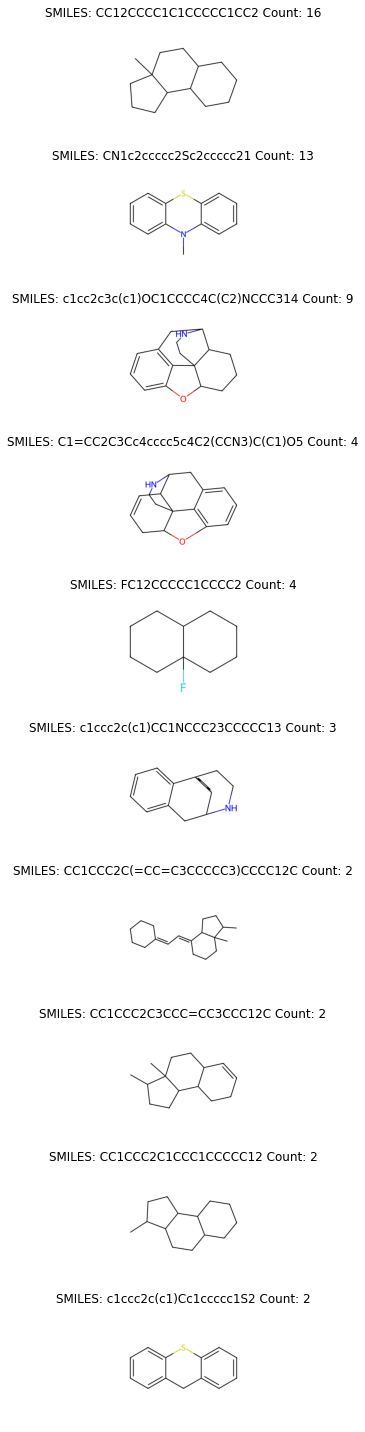

In [76]:
# Create a list of molecule objects from SMILES strings
mols = [Chem.MolFromSmiles(smiles) for smiles in vals.keys()]

# Setting up the plot
fig, axes = plt.subplots(nrows=len(mols), figsize=(10, len(mols) * 2))

# If there is only one molecule, we need to ensure axes is iterable
if len(mols) == 1:
    axes = [axes]

# Draw each molecule with its SMILE and count
for ax, mol, (smiles, count) in zip(axes, mols, vals.items()):
    img = Draw.MolToImage(mol, size=(300, 300))
    ax.imshow(img)
    ax.axis('off')
    ax.set_title(f'SMILES: {smiles} Count: {count}')

plt.tight_layout()
plt.show()

In [77]:
# Create lists for DataFrame  Substructures pharmaceuticals construction
smiles_list = list(vals.keys())
mol_objects = [Chem.MolFromSmiles(sm) for sm in smiles_list]
counts_list = list(vals.values())

# Create the DataFrame
sub_interpret_pharma = pd.DataFrame({
    'smiles_substructures': smiles_list,
    'mol': mol_objects,
    'Count': counts_list
})

sub_interpret_pharma

,smiles_substructures,mol,Count
0,CC12CCCC1C1CCCCC1CC2,<rdkit.Chem.rdchem.Mol object at 0x7fdc5f623ed0>,16
1,CN1c2ccccc2Sc2ccccc21,<rdkit.Chem.rdchem.Mol object at 0x7fdc5f7edf90>,13
2,c1cc2c3c(c1)OC1CCCC4C(C2)NCCC314,<rdkit.Chem.rdchem.Mol object at 0x7fdc5f7edcf0>,9
3,C1=CC2C3Cc4cccc5c4C2(CCN3)C(C1)O5,<rdkit.Chem.rdchem.Mol object at 0x7fdc5f78bcf0>,4
4,FC12CCCCC1CCCC2,<rdkit.Chem.rdchem.Mol object at 0x7fdc5f78bab0>,4
5,c1ccc2c(c1)CC1NCCC23CCCCC13,<rdkit.Chem.rdchem.Mol object at 0x7fdc5f78b4b0>,3
6,CC1CCC2C(=CC=C3CCCCC3)CCCC12C,<rdkit.Chem.rdchem.Mol object at 0x7fdc5f78b0f0>,2
7,CC1CCC2C3CCC=CC3CCC12C,<rdkit.Chem.rdchem.Mol object at 0x7fdc5f78b750>,2
8,CC1CCC2C1CCC1CCCCC12,<rdkit.Chem.rdchem.Mol object at 0x7fdc5f78b870>,2
9,c1ccc2c(c1)Cc1ccccc1S2,<rdkit.Chem.rdchem.Mol object at 0x7fdc5f78bd50>,2


### **Table S3**

### **PBT-relevant substructures from pharmaceuticals.**

The following code analyzes each substructure in `pharma_pred_AD` by identifying matching molecules in `prediction_pharmadf` and gathering label statistics. Here’s a brief overview:

1. **Match Substructures**: For each substructure, find molecules in `pharma_pred_AD` that contain it.
2. **Filter and Count Labels**: For matched molecules, count the occurrences of `PBT_DL_bin_pred` label `1` (positive) and `0` (negative).
3. **Collect Names with Positive Labels**: Gather names of molecules with a label of `1` and store them in a list.
4. **Display Results**: For each substructure, print its SMILES representation, total matches, counts of labels, and names of molecules with a positive label.

In [78]:
pharma_pred_AD

,DB_smiles,PBT_label,CAS,DB_name,QSAR_consensus,PBT_DL_bin_pred,mol
0,N[C@@H](Cc1c[nH]cn1)C(=O)O,0.000045,000071-00-1,Histidine,0,0,<rdkit.Chem.rdchem.Mol object at 0x7fdc5cff9bd0>
1,N[C@@H](Cc1ccccc1)C(=O)O,0.000155,000063-91-2,Phenylalanine,0,0,<rdkit.Chem.rdchem.Mol object at 0x7fdc5cff9e70>
2,O=C(O)CCCC[C@@H]1SC[C@@H]2NC(=O)N[C@@H]21,0.000324,000058-85-5,Biotin,0,0,<rdkit.Chem.rdchem.Mol object at 0x7fdc5cff9d50>
3,NCCCC[C@@H](N)C(=O)O,0.000015,000056-87-1,Lysine,0,0,<rdkit.Chem.rdchem.Mol object at 0x7fdc5cff94b0>
4,NCCCNCCCCNCCCN,0.000118,000071-44-3,Spermine,0,0,<rdkit.Chem.rdchem.Mol object at 0x7fdc5cff96f0>
...,...,...,...,...,...,...,...
542,COc1cc(CC(C)N)cc2c1OCO2,0.004641,013674-05-0,"Phenethylamine, 3-methoxy-α-methyl-4,5-(methyl...",0,0,<rdkit.Chem.rdchem.Mol object at 0x7fdc5d01bb10>
543,CC(N)C(O)c1ccccc1,0.000931,014838-15-4,"Norephedrine, (.+/-.)-",0,0,<rdkit.Chem.rdchem.Mol object at 0x7fdc5d01bb70>
544,COc1cc(CC(C)N)c(OC)cc1C,0.027564,015588-95-1,"Benzeneethanamine, 2,5-dimethoxy-α,4-dimethyl-",0,0,<rdkit.Chem.rdchem.Mol object at 0x7fdc5d01bbd0>
545,CNC(C)Cc1ccc2c(c1)OCO2,0.006475,042542-10-9,"N-Methyl-3,4-methylenedioxyamphetamine",0,0,<rdkit.Chem.rdchem.Mol object at 0x7fdc5d01bc30>


In [79]:
print("Substructures interpret pharma in the pharmaceutical dataset")

molecules_with_label_1 = []

# Iterate through each substructure and perform the analysis
for i, substructure in enumerate(sub_interpret_pharma['mol']):
    # Find matches for the current substructure in the dataset
    highlight_lists = [mol.GetSubstructMatch(substructure) for mol in pharma_pred_AD['mol']]
    
    # Filter matched molecules
    matched_indices = [i for i, match in enumerate(highlight_lists) if match]
    matched_molecules = pharma_pred_AD.iloc[matched_indices]

    # Extract PBT_labels and names for matched molecules
    matched_labels = matched_molecules['PBT_DL_bin_pred']
    matched_names = matched_molecules['DB_name']
    
    # Count occurrences of 1 and 0 in PBT_labels
    count_label_1 = sum(matched_labels)
    count_label_0 = len(matched_labels) - count_label_1

    # Collect names for molecules with PBT_label 1
    names_label_1 = matched_names[matched_labels == 1].tolist()
    molecules_with_label_1.extend(names_label_1)  # Extend the list with new findings
    
    # Print results for verification
    print(f"PC {i}: {Chem.MolToSmiles(substructure)}")
    print(f"Total matches: {len(matched_indices)}")
    print(f"Count of '1' in PBT_label: {count_label_1}")
    print(f"Count of '0' in PBT_label: {count_label_0}")
    print(f"Names with 'PBT_label' = 1: {', '.join(names_label_1)}")
    print("-" * 40)

Substructures interpret pharma in the pharmaceutical dataset
PC 0: CC12CCCC1C1CCCCC1CC2
Total matches: 33
Count of '1' in PBT_label: 27
Count of '0' in PBT_label: 6
Names with 'PBT_label' = 1: Progesterone, Spironolactone, Betamethasone, Medroxyprogesterone acetate, Triamcinolone, Oxandrolone, Testosterone, Hydrocortamate, Drostanolone, Fluoxymesterone, Budesonide, Dexamethasone, Testosterone propionate, Bolasterone, Furazabol, Androstenedione, Boldenone, Calusterone, Stanolone, Oxymetholone, Stanozolol, Finasteride, Cortisone Acetate, 17α-Methyltestosterone, Androstane-3,17-dione, (5α)-, Androst-4-en-3-one, 4-chloro-17-hydroxy-, (17β)-, Androstane-3,17-diol, (3α,5α,17β)-
----------------------------------------
PC 1: CN1c2ccccc2Sc2ccccc21
Total matches: 13
Count of '1' in PBT_label: 13
Count of '0' in PBT_label: 0
Names with 'PBT_label' = 1: Promazine, Chlorpromazine, Propiomazine, Perphenazine, Acetophenazine, Promethazine, Methotrimeprazine, Periciazine, Acepromazine, Thioproperazin

In the following steps we identified **Molecules experimentally detected in environmental media according Howard and Miur** with confirmed PBT positive behavior according to our model prediction.

### **Howard and Miur molecules detected in environmental media**

In [80]:
HM_mol = pd.read_csv('Datasets/pharma_environment.csv', sep =';')
HM_mol

,ID,Molstructure
0,000050-78-2,Acetylsalicylic Acid
1,000051-21-8,Fluorouracil
2,000051-48-9,Synthroid (Thyroxine)
3,000052-53-9,Verapamil SR
4,000052-86-8,Haloperidol
...,...,...
267,000050-33-9,Phenylbutazone
268,000050-36-2,Cocaine
269,000050-48-6,Amitriptyline
270,000050-49-7,Imipramine


In [52]:
## dataframe with molecules in the pharmaceutical dataset with a PBT positive behavior
df_label_1 = pd.DataFrame(molecules_with_label_1, columns=['Molecule Name'])
df_label_1

,Molecule Name
0,Progesterone
1,Spironolactone
2,Betamethasone
3,Medroxyprogesterone acetate
4,Triamcinolone
...,...
94,Finasteride
95,Cortisone Acetate
96,17α-Methyltestosterone
97,Chlorprothixene


In [53]:
## Find molecules with a positive PBT behavior in common with Howar and Miur dataset
common_pharmainterp = df_label_1['Molecule Name'].isin(HM_mol['Molstructure'])
common_ph = df_label_1[common_pharmainterp]
common_ph

,Molecule Name
6,Testosterone
15,Androstenedione
41,Oxycodone
44,Hydrocodone
52,Morphine
53,Codeine
63,Oxycodone
69,Hydrocodone
